In [67]:
# filter warnings
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn import metrics

from sklearn.linear_model import LogisticRegressionCV,LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer

In [68]:
data=pd.read_json('reviews_Office_Products_5.json',lines=True)

In [69]:
data.head()

,asin,helpful,overall,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime
0,B00000JBLH,"[3, 4]",5,"I bought my first HP12C in about 1984 or so, a...","09 3, 2004",A32T2H8150OJLU,ARH,"A solid performer, and long time friend",1094169600
1,B00000JBLH,"[7, 9]",5,WHY THIS BELATED REVIEW? I feel very obliged t...,"12 15, 2007",A3MAFS04ZABRGO,"Let it Be ""Alan""","Price of GOLD is up, so don't bury the golden ...",1197676800
2,B00000JBLH,"[3, 3]",2,I have an HP 48GX that has been kicking for mo...,"01 1, 2011",A1F1A0QQP2XVH5,Mark B,"Good functionality, but not durable like old HPs",1293840000
3,B00000JBLH,"[7, 8]",5,I've started doing more finance stuff recently...,"04 19, 2006",A49R5DBXXQDE5,R. D Johnson,One of the last of an almost extinct species,1145404800
4,B00000JBLH,"[0, 0]",5,For simple calculations and discounted cash fl...,"08 4, 2013",A2XRMQA6PJ5ZJ8,Roger J. Buffington,Still the best,1375574400


In [70]:
# Data preprocessing
data['overall'] = data['overall'].astype(object) # fix datatype error
dataset = {"reviewText": data["reviewText"], "overall": data["overall"]  }
dataset = pd.DataFrame(data = dataset)
dataset = dataset.dropna()

In [71]:
dataset.head()

,reviewText,overall
0,"I bought my first HP12C in about 1984 or so, a...",5
1,WHY THIS BELATED REVIEW? I feel very obliged t...,5
2,I have an HP 48GX that has been kicking for mo...,2
3,I've started doing more finance stuff recently...,5
4,For simple calculations and discounted cash fl...,5


In [72]:
dataset.dtypes

reviewText    object
overall       object
dtype: object

In [73]:
dataset['overall']=dataset['overall'].astype('int64')

In [74]:
dataset.shape

(53258, 2)

In [75]:
dataset = dataset[dataset["overall"] != 3] # need datatype=object


In [76]:
dataset.shape

(48198, 2)

In [77]:
dataset["overall"].isnull().any()

False

In [78]:
dataset["label"] = dataset["overall"].apply(lambda x : 1 if x > 3 else 0)

In [79]:
dataset["label"].isnull().any()

False

In [80]:
dataset[dataset["label"].isnull()]

,reviewText,overall,label


In [81]:
dataset.head()

,reviewText,overall,label
0,"I bought my first HP12C in about 1984 or so, a...",5,1
1,WHY THIS BELATED REVIEW? I feel very obliged t...,5,1
2,I have an HP 48GX that has been kicking for mo...,2,0
3,I've started doing more finance stuff recently...,5,1
4,For simple calculations and discounted cash fl...,5,1


In [82]:
dataset.label.value_counts()

1    45342
0     2856
Name: label, dtype: int64

In [83]:
dataset.overall.value_counts()

5    30327
4    15015
2     1726
1     1130
Name: overall, dtype: int64

In [84]:
2856/(2856+45342)

0.05925557077057139

In [85]:
#Function to calculate Model Metrics

def get_model_metrics(actual,predicted):
    """
    Print Summary Metrics of the Model

    Parameters:
    actual (pandas.core.series.Series): Series of Boolean values for target column
    predicted (pandas.core.series.Series): Series of Boolean values for Model predicted the target column
    
    Returns:
    None

   """

    
    confusion = metrics.confusion_matrix(actual,predicted )
    TP = confusion[1,1] # true positive 
    TN = confusion[0,0] # true negatives
    FP = confusion[0,1] # false positives
    FN = confusion[1,0] # false negatives
    accuracy=metrics.accuracy_score(actual,predicted)
    sensitivity = TP / float(TP+FN)
    specificity = TN / float(TN+FP)
    precision=TP/float(FP+TP)
    recall=TP/float(FN+TP)
    
    precision=metrics.precision_score(actual,predicted)
    recall=metrics.recall_score(actual,predicted)
    f1=metrics.f1_score(actual,predicted, average='weighted') 
    print("Accuracy    : "+str(round(accuracy,2)))
    print("Sensitivity : "+str(round(sensitivity,2)))
    print("Specificity : "+str(round(specificity,2)))
    print("Precision   : "+str(round(precision,2)))
    print("Recall      : "+str(round(recall,2)))
    print("F1_score    : "+str(round(f1,2)))

def get_cross_validated_model_metrics(X,y,cv=5):
    """
    Get cross validated model metric for k folds

    Parameters:
    X (pandas.core.frame.DataFrame): DF of all the features excluding target column
    y (pandas.core.series.Series): Series of Boolean values of the target column
    
    Returns:
    df (pandas.core.frame.DataFrame): DF will all the metric for k fold

   """
    accuracy=cross_val_score(logregcv, X, y, cv=cv,n_jobs=-1,scoring='accuracy')
    precision=cross_val_score(logregcv, X, y, cv=cv,n_jobs=-1,scoring='precision')
    recall=cross_val_score(logregcv, X, y, cv=cv,n_jobs=-1,scoring='recall')
    f1_weighted=cross_val_score(logregcv, X, y, cv=cv,n_jobs=-1,scoring='f1_weighted')
    roc_auc=cross_val_score(logregcv, X, y, cv=cv,n_jobs=-1,scoring='roc_auc')
    df=pd.DataFrame(
    {'accuracy': accuracy,
     'precision': precision,
     'recall': recall,
     'f1_weighted': f1_weighted,
     'roc_auc': roc_auc,
    })
    return df

logregcv = LogisticRegressionCV(class_weight='balanced',cv=5)

In [86]:
from sklearn.model_selection import train_test_split

X = pd.DataFrame(dataset, columns = ["reviewText"])
y = pd.DataFrame(dataset, columns = ["label"])

X_train , X_test , y_train , y_test = train_test_split(X, y, random_state=50,stratify=y,train_size=0.7)

In [87]:
X_train.head()

,reviewText
30346,"When I think Sharpie, I think BOLD. I think cl..."
466,"Avery has some of the best products, and this ..."
4335,I use these to write first drafts. I continua...
37664,There are so many printers on the market that ...
35986,When I read reference books I like to note sec...


In [88]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(token_pattern=r'\b\w+\b')
train_vector = vectorizer.fit_transform(X_train["reviewText"])
test_vector = vectorizer.transform(X_test["reviewText"])

In [112]:
X_train["reviewText"]

30346    When I think Sharpie, I think BOLD. I think cl...
466      Avery has some of the best products, and this ...
4335     I use these to write first drafts.  I continua...
37664    There are so many printers on the market that ...
35986    When I read reference books I like to note sec...
5194     After sitting in the same cube for seven years...
9323     I've been using Epson C88 and C88+ printers fo...
33323    I already own a similar but lower-priced Canon...
24792    I really like these pens. I found them to writ...
6655     This is a lot of tape for a good price with th...
11968    I was very pleased to find these folders well-...
35324    I liked the measurement of 3x3 and the colours...
39459    These pens are so pretty with some white patte...
15340    I absolutely love this product. I have a wirel...
24151    This little stapler may not look like a powerf...
25234    As my past experience with other Avery product...
29022    These are really cute little magnets that you .

In [89]:


log_reg_model = LogisticRegressionCV(class_weight='balanced')
log_reg_model.fit(train_vector, y_train)
scores = log_reg_model.score(test_vector, y_test) # accuracy
print(scores)

0.9359612724757953


In [90]:
#Making prediction on the train data
y_train_pred = log_reg_model.predict_proba(train_vector)[:,1]

In [91]:
#Making prediction on the test data
y_pred = log_reg_model.predict_proba(test_vector)[:,1]

In [92]:
y_train_pred=pd.Series(y_train_pred)
y_pred=pd.Series(y_pred)

In [93]:
y_pred_bool= y_pred.apply(lambda x: 1 if x>=0.5 else 0)
y_train_pred_bool= y_train_pred.apply(lambda x: 1 if x>=0.5 else 0)

In [94]:
metrics.confusion_matrix(y_train,y_train_pred_bool)

array([[ 1996,     3],
       [  204, 31535]])

In [95]:
get_model_metrics(y_train,y_train_pred_bool)

Accuracy    : 0.99
Sensitivity : 0.99
Specificity : 1.0
Precision   : 1.0
Recall      : 0.99
F1_score    : 0.99


In [96]:
metrics.confusion_matrix(y_test,y_pred_bool)

array([[  514,   343],
       [  583, 13020]])

In [97]:
get_model_metrics(y_test,y_pred_bool)

Accuracy    : 0.94
Sensitivity : 0.96
Specificity : 0.6
Precision   : 0.97
Recall      : 0.96
F1_score    : 0.94


In [98]:
train_output=pd.DataFrame({'y_train':y_train['label'],'y_pred':y_train_pred,'y_train_pred_bool':y_train_pred_bool})
test_output=pd.DataFrame({'y_test':y_test['label'],'y_pred':y_pred,'y_pred_bool':y_pred_bool})

In [99]:
train_output['y_train'].fillna(0,inplace=True)
test_output['y_test'].fillna(0,inplace=True)

In [100]:
train_output.head(10)

,y_train,y_pred,y_train_pred_bool
0,0.0,0.000285,0.0
1,1.0,0.999999,1.0
2,0.0,0.995388,1.0
3,1.0,1.000000,1.0
4,1.0,0.999967,1.0
5,0.0,0.895349,1.0
6,1.0,1.000000,1.0
7,1.0,1.000000,1.0
8,1.0,0.990456,1.0
9,0.0,0.947115,1.0


In [101]:
test_output.head(10)

,y_test,y_pred,y_pred_bool
0,1.0,0.041453,0.0
1,0.0,0.964047,1.0
2,0.0,1.000000,1.0
3,0.0,0.999931,1.0
4,0.0,0.999673,1.0
5,1.0,1.000000,1.0
6,0.0,1.000000,1.0
7,0.0,0.999763,1.0
8,0.0,0.999967,1.0
9,1.0,0.999995,1.0


In [102]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

def draw_roc( actual, probs ):
    fpr, tpr, thresholds = metrics.roc_curve( actual, probs,
                                              drop_intermediate = False )
    auc_score = metrics.roc_auc_score( actual, probs )
    plt.figure(figsize=(5, 5))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

    return None

In [103]:
fpr, tpr, thresholds = metrics.roc_curve(y_train,y_train_pred , drop_intermediate = False )

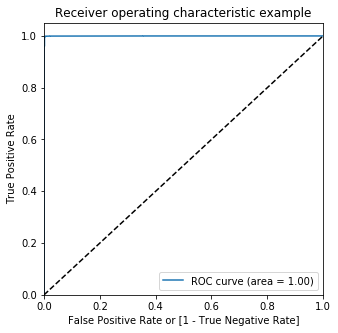

In [104]:
draw_roc(y_train,y_train_pred)

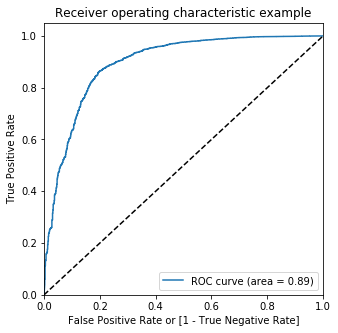

In [105]:
draw_roc(y_test,y_pred)

In [106]:
# Now let's calculate accuracy sensitivity and specificity for various probability cutoffs.
cutoff_df = pd.DataFrame( columns = ['prob','accuracy','sensi','speci'])
from sklearn.metrics import confusion_matrix

# confusion=confusion_matrix(df['y'],df['y_prob'])

# TP = confusion[1,1] # true positive 
# TN = confusion[0,0] # true negatives
# FP = confusion[0,1] # false positives
# FN = confusion[1,0] # false negatives

def threshold_optimization(y,num):
    #pass the prediction_probability series and threshold probabilty cutoff
    y_bool= y.apply(lambda x: 1 if x>=num else -1)
    return y_bool

num = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
for i in num:
    cm1 = metrics.confusion_matrix(y_train,threshold_optimization(y_train_pred,i))
#     print(cm1)
    total1=sum(sum(cm1))
    accuracy = (cm1[0,0]+cm1[1,1])/total1
    
    speci = cm1[0,0]/(cm1[0,0]+cm1[0,1])
    sensi = cm1[1,1]/(cm1[1,0]+cm1[1,1])
    cutoff_df.loc[i] =[ i ,accuracy,sensi,speci]
print(cutoff_df)

     prob  accuracy  sensi  speci
0.0   0.0  0.940749    1.0    0.0
0.1   0.1  0.000000    0.0    NaN
0.2   0.2  0.000000    0.0    NaN
0.3   0.3  0.000000    0.0    NaN
0.4   0.4  0.000000    0.0    NaN
0.5   0.5  0.000000    0.0    NaN
0.6   0.6  0.000000    0.0    NaN
0.7   0.7  0.000000    0.0    NaN
0.8   0.8  0.000000    0.0    NaN
0.9   0.9  0.000000    0.0    NaN


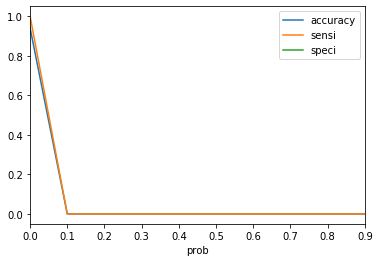

In [107]:

cutoff_df.plot.line(x='prob', y=['accuracy','sensi','speci'])
plt.show()

In [108]:
get_model_metrics(df['y'],df['predict_bool'] )

NameError: name 'df' is not defined

In [ ]:
cross_validated_train_metrics=get_cross_validated_model_metrics(train_vector, y_train,5)

In [ ]:
cross_validated_train_metrics

In [ ]:
cross_validated_train_metrics.mean()